In [22]:
import time

import numpy as np
from scipy.stats import rv_continuous

import matplotlib.pyplot as plt
from scipy.stats import norm, weibull_min

### **Использование rv_continuous из SciPy**

In [3]:
class CustomDistridution(rv_continuous):
    def _pdf(self, x):
        return (3 * (x**2) / np.sqrt(2 * np.pi)) * np.exp(-(5 - x**3)**2/2)

In [4]:
custom_dst = CustomDistridution(name='CustomDistribution')


Время генерации 100 чисел методом обратной функции: 0.5310 секунд


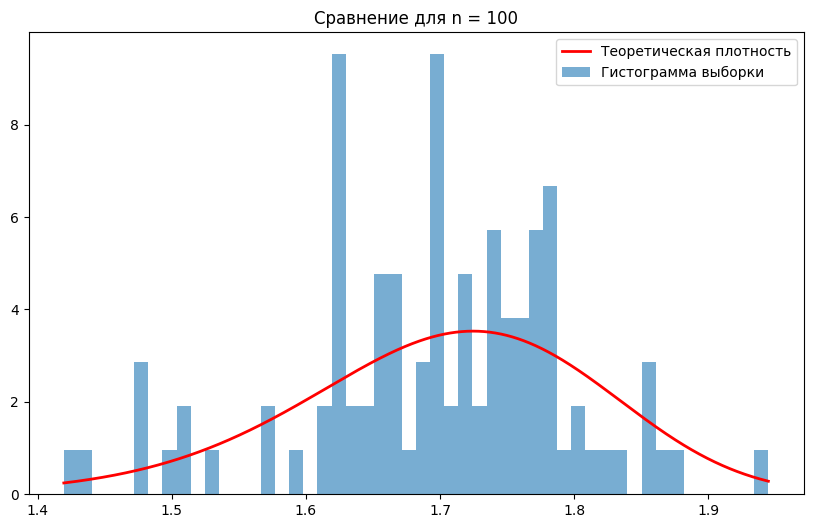

Время генерации 1000 чисел методом обратной функции: 5.8515 секунд


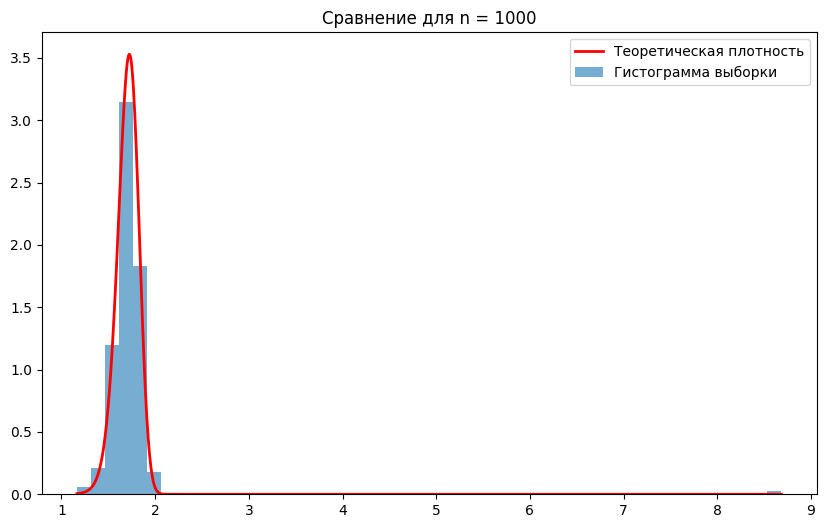

Время генерации 10000 чисел методом обратной функции: 61.1805 секунд


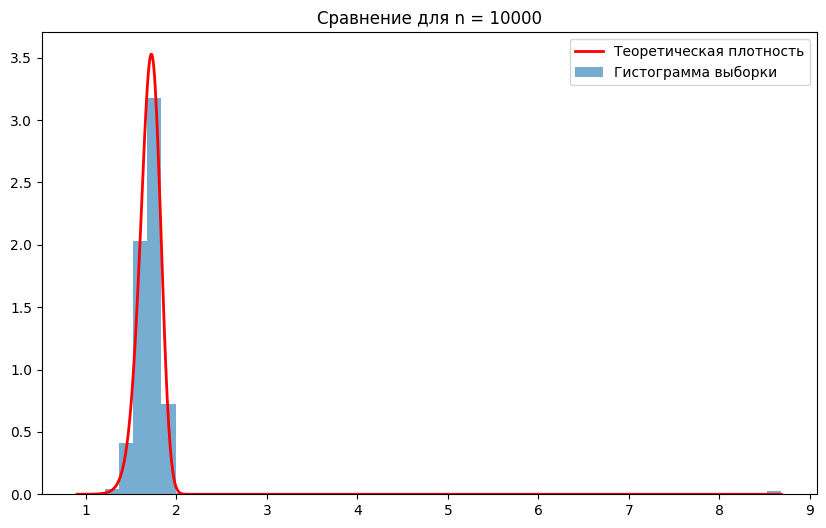

In [30]:
n_values = [100, 1000, 10000]
for n in n_values:
    start = time.time()
    samples = custom_dst.rvs(size=n)
    end = time.time()
    print(f"Время генерации {n} чисел методом обратной функции: {end - start:.4f} секунд")

    plt.figure(figsize=(10, 6))
    x = np.linspace(samples.min(), samples.max(), 1000)
    plt.plot(x, custom_dst.pdf(x), 'r-', lw=2, label='Теоретическая плотность')
    plt.hist(samples, bins=50, density=True, histtype='stepfilled', alpha=0.6, label='Гистограмма выборки')
    plt.title(f'Сравнение для n = {n}')
    plt.legend()
    plt.show()

### **Метод обратной функции распределения**

#### Нахождение функции распределения $F(x)$

$$
F(x) = \int_{0}^{x} p(t) dt = \int_{0}^{x} \frac{3t^2}{\sqrt{2\pi}} e^{-\frac{(5-t^3)^2}{2}} dt
$$

Пусть $u = 5 - t^3$. Тогда $du = -3t^2 dt$.
- Если $t=0$, то $u = 5 - 0^3 = 5$.
- Если $t=x$, то $u = 5 - x^3$.

$$
F(x) = \frac{1}{\sqrt{2\pi}} \int_{5}^{5-x^3} e^{-\frac{u^2}{2}} (-du)
$$
$$
F(x) = \frac{1}{\sqrt{2\pi}} \int_{5-x^3}^{5} e^{-\frac{u^2}{2}} du
$$

Выражение под интегралом — это плотность стандартного нормального распределения. Поэтому сам интеграл можно выразить через функцию распределения стандартного нормального закона $\Phi(z)$:

$$
F(x) = \Phi(5) - \Phi(5 - x^3)
$$

#### Нахождение обратной функции $F^{-1}(y)$

Решим уравнение $y = F(x)$ относительно $x$, чтобы найти обратную функцию $x = F^{-1}(y)$:

$$
y = \Phi(5) - \Phi(5 - x^3)
$$

$$
\Phi(5 - x^3) = \Phi(5) - y
$$

$$
5 - x^3 = \Phi^{-1}(\Phi(5) - y)
$$

$$
x^3 = 5 - \Phi^{-1}(\Phi(5) - y)
$$

$$
x = \left(5 - \Phi^{-1}(\Phi(5) - y)\right)^{\frac{1}{3}}
$$

In [20]:
def inverse_transform_sampling(n):
    u = np.random.uniform(0, 1, n)
    return (5 - norm.ppf(norm.cdf(5) - u))**(1/3)

Время генерации 100 чисел методом обратной функции: 0.0061 секунд


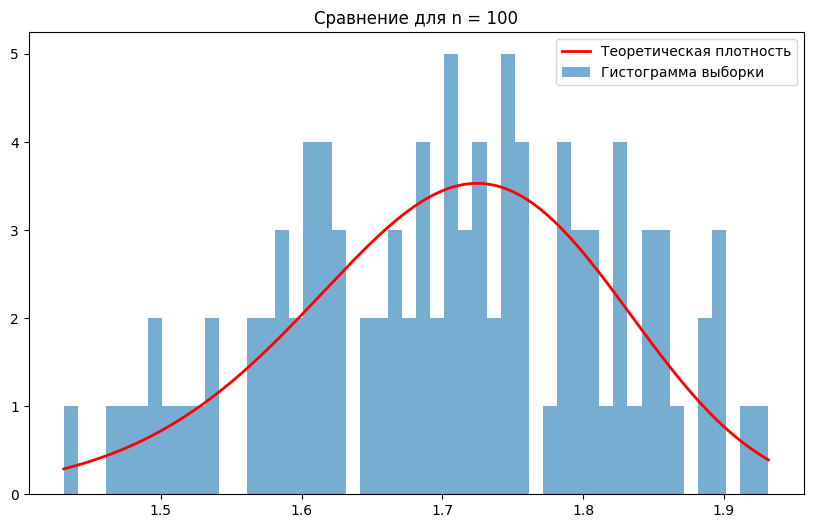

Время генерации 1000 чисел методом обратной функции: 0.0020 секунд


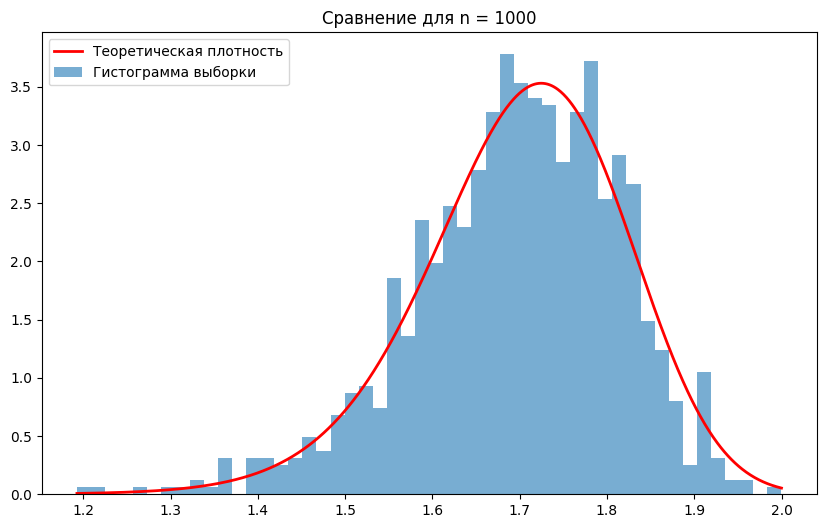

Время генерации 10000 чисел методом обратной функции: 0.0035 секунд


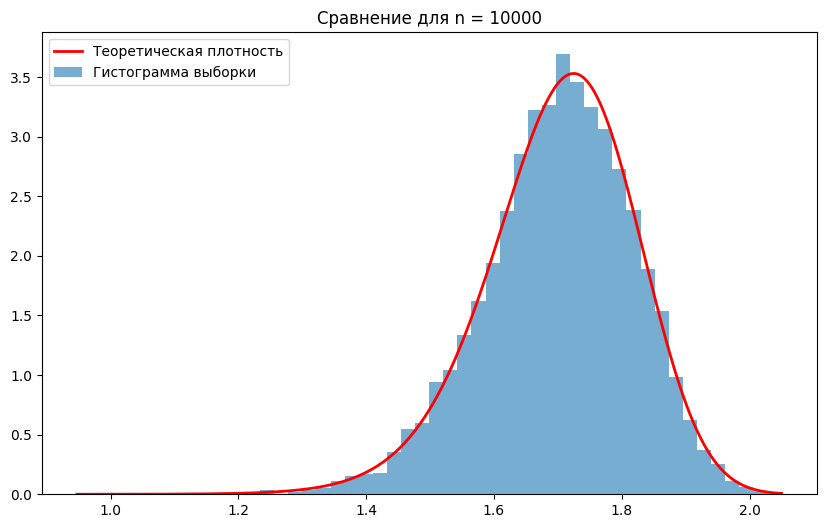

In [21]:
for n in n_values:
    start_time = time.time()
    sample = inverse_transform_sampling(n)
    end_time = time.time()
    print(f"Время генерации {n} чисел методом обратной функции: {end_time - start_time:.4f} секунд")

    plt.figure(figsize=(10, 6))
    x = np.linspace(sample.min(), sample.max(), 1000)
    plt.plot(x, custom_dst.pdf(x), 'r-', lw=2, label='Теоретическая плотность')
    plt.hist(sample, bins=50, density=True, histtype='stepfilled', alpha=0.6, label='Гистограмма выборки')
    plt.title(f'Сравнение для n = {n}')
    plt.legend()
    plt.show()

### **Метод выборочного отклонения**

В качестве огибающей функции возьмем плотность распределения Вейбулла, которая имеет схожую форму.

$$
f(x; k, \lambda) = \frac{k}{\lambda} \left( \frac{x}{\lambda} \right)^{k-1} e^{-(x/\lambda)^k} \quad \text{для } x \ge 0
$$

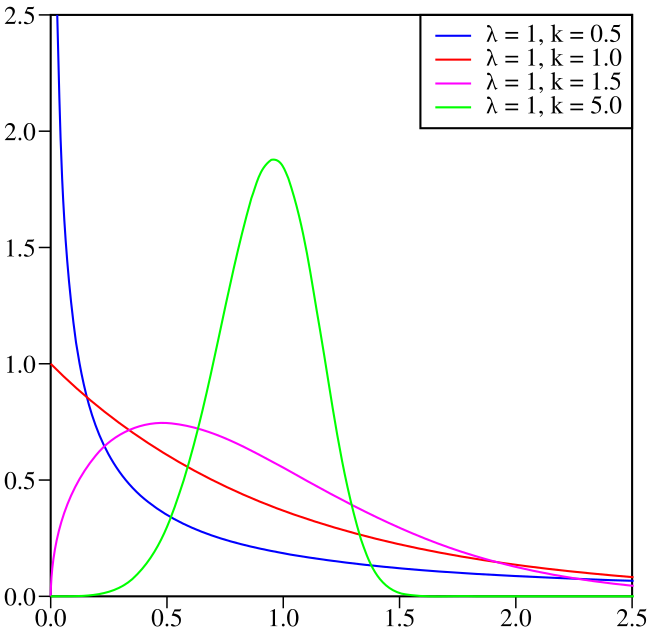

In [28]:
def rejection_sampling(n):
    c = 1.5 # параметр формы (k)
    scale = 1.8 # параметр масштаба (lambda)
    x_vals = np.linspace(1e-5, 5, 1000)
    M = np.max(custom_dst.pdf(x_vals) / weibull_min.pdf(x_vals, c, scale=scale))

    result = []
    while len(result) < n:
        y = weibull_min.rvs(c, scale=scale, size=1)[0]
        u = np.random.uniform(0, 1)
        if u <= custom_dst.pdf(y) / (M * weibull_min.pdf(y, c, scale=scale)):
            result.append(y)
    return np.array(result)

Время генерации 100 чисел методом выборочного отклонения: 0.1108 секунд


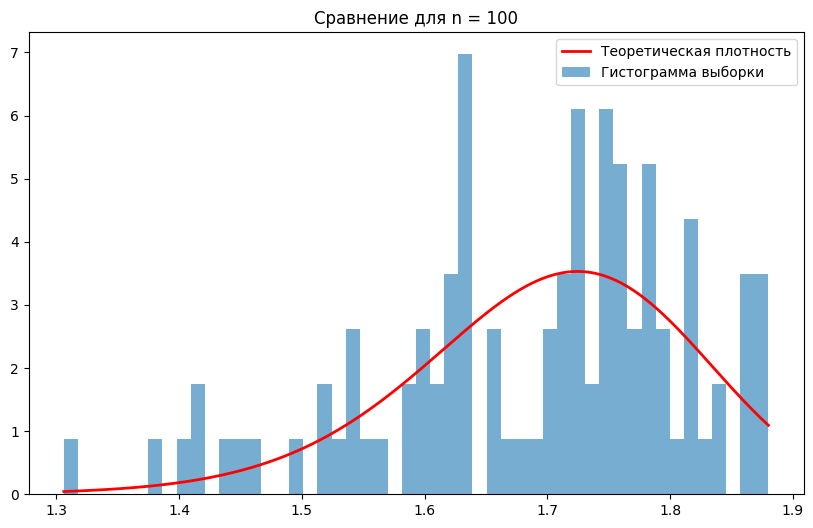

Время генерации 1000 чисел методом выборочного отклонения: 1.1991 секунд


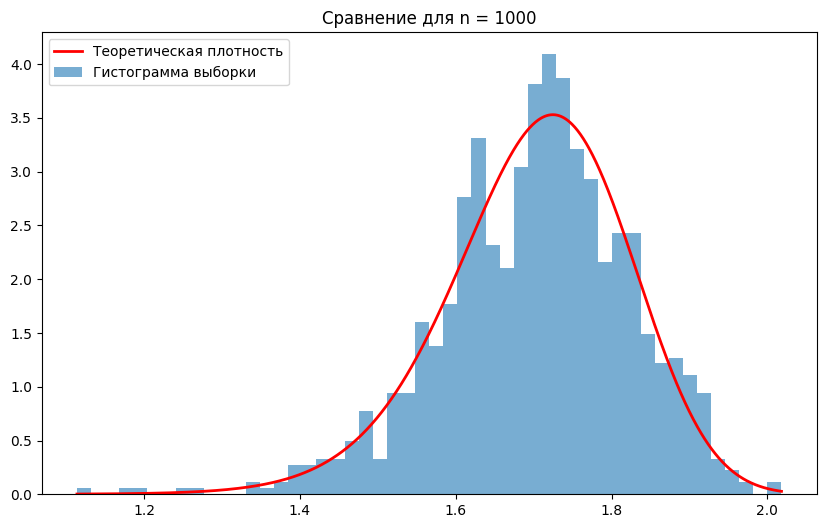

Время генерации 10000 чисел методом выборочного отклонения: 9.8863 секунд


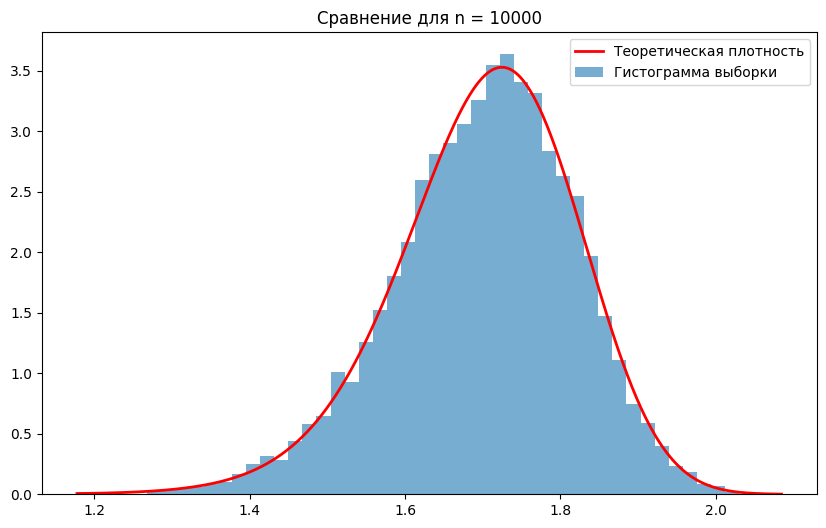

In [29]:
for n in n_values:
    start_time = time.time()
    sample = rejection_sampling(n)
    end_time = time.time()
    print(f"Время генерации {n} чисел методом выборочного отклонения: {end_time - start_time:.4f} секунд")


    plt.figure(figsize=(10, 6))
    x = np.linspace(sample.min(), sample.max(), 1000)
    plt.plot(x, custom_dst.pdf(x), 'r-', lw=2, label='Теоретическая плотность')
    plt.hist(sample, bins=50, density=True, histtype='stepfilled', alpha=0.6, label='Гистограмма выборки')
    plt.title(f'Сравнение для n = {n}')
    plt.legend()
    plt.show()